# PyTorch Binary Classification

The purpose of this project is to showcase how the fundamental components of neural networks can be used to create a binary classification model using the PyTorch Library.

# Data Gathering

To begin our analysis, we'll import the statcast_pitcher method from the pybaseball library. This method allows us to access a wide range of statistics related to pitchers in Major League Baseball. Specifically, we'll be focusing on the statistics of player ID 477132 from 2015-01-01 to 2016-01-01, which we'll use to train and test our binary classification model.

In [1]:
from pybaseball import statcast_pitcher
import pandas as pd
import numpy as np

In [2]:
df = statcast_pitcher('2015-01-01', '2016-01-01', 477132)

Gathering Player Data


In [3]:
df.head(3)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,SL,2015-10-13,90.4,1.30,6.16,"Kershaw, Clayton",527038,477132,field_out,hit_into_play,...,3,3,1,1,3,Standard,Strategic,NaN,-0.038,-0.297
1,FF,2015-10-13,95.6,1.24,5.95,"Kershaw, Clayton",527038,477132,NaN,ball,...,3,3,1,1,3,Standard,Strategic,NaN,0.000,0.041
2,FF,2015-10-13,95.2,1.16,5.99,"Kershaw, Clayton",527038,477132,NaN,ball,...,3,3,1,1,3,Standard,Standard,NaN,0.000,0.032


# Define X and y
#### `EDA Prior Machine Learning`
<br/>
Understanding our data (X and y) and perform simple Exploratory Data Analysis. 

Some important points to note about strikes and balls in baseball are:

- A strike is when the pitcher throws the ball into the strike zone, and the batter doesn't swing, or when the batter swings and misses the ball, regardless of whether the ball is in the strike zone or not. If a batter gets three strikes, they're out.
- A ball is when the pitcher throws the ball outside the strike zone, and the batter doesn't swing. If a batter gets four balls, they are allowed to go to first base.
- In our dataset, the 'type' feature of each row is either 'S' for a strike, 'B' for a ball, or 'X' for neither.
- To use this feature as the label of our data points, we'll convert every 'S' to a 1 and every 'B' to a 0 using the map() function of a DataFrame column.

#### `Defining our labels (y)`
<br/>
Our main focus is to determine whether a pitch is categorized as a 'strike' or a 'ball', which is stored in the 'type' feature of our dataset. To gain an understanding of how balls and strikes are recorded in the dataset, let's examine the unique values stored in the 'type' feature. This will enable us to identify any inconsistencies or missing values in the data and determine the number of different types of pitches included in our dataset.

`Unique label values`

In [4]:
df.type.unique()

array(['X', 'B', 'S'], dtype=object)

`Frequency and proportion check`

In [5]:
# Since the 'X' values in our dataset are neither strikes nor balls, they are not useful for our binary classification task.
# Thus, we'll drop these values later on as they won't contribute to our analysis.
print(df.type.value_counts())
print(((df.type.value_counts() / len(df)) * 100).round(2).astype(str) + '%')

S    1969
B    1213
X     628
Name: type, dtype: int64
S    51.68%
B    31.84%
X    16.48%
Name: type, dtype: object


`New label unique values`

In [6]:
df['type_mapped'] = df['type'].map({'S':1, 'B':0})
df.type.unique()

array(['X', 'B', 'S'], dtype=object)

`Drop all rows containing NaN values in the 'type' column`

In [7]:
df = df.dropna(subset = ['type_mapped'])
df.type.unique()

array(['B', 'S'], dtype=object)

`Check the proportion of our new labels`

In [8]:
print(((df.type_mapped.value_counts() / len(df)) * 100).round(2).astype(str) + '%')

1.0    61.88%
0.0    38.12%
Name: type_mapped, dtype: object


#### `Defining our features (X)`

To predict whether a pitch is a ball or a strike based on its location over the plate, we can use the columns plate_x and plate_z to find the location of the ball.

- plate_x measures how far left or right the pitch is from the center of home plate. A plate_x value of 0 indicates that the pitch was directly in the middle of the home plate.
- plate_z measures how high off the ground the pitch was. A plate_z value of 0 indicates that the pitch was at ground level when it reached the home plate.

`Check for null values`

In [9]:
df[['plate_x', 'plate_z']].isna().sum()

plate_x    65
plate_z    65
dtype: int64

`Drop null values`

In [10]:
df = df.dropna(subset = ['plate_x', 'plate_z'])
df[['plate_x', 'plate_z', 'type_mapped']].isna().sum()

plate_x        0
plate_z        0
type_mapped    0
dtype: int64

#### Visualize our new datasets (cleaned)

In [11]:
df_cleaned = df[['plate_x', 'plate_z','type_mapped']]
df_cleaned.head(3)

,plate_x,plate_z,type_mapped
1,-0.08,1.02,0.0
2,-0.32,1.41,0.0
5,0.28,2.02,1.0


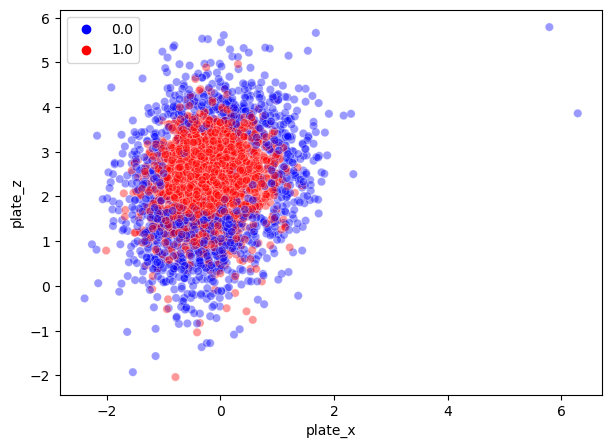

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(7,5))
sns.scatterplot(df_cleaned['plate_x'], df_cleaned['plate_z'], hue = df_cleaned['type_mapped'], palette=['blue', 'red'], alpha = 0.4)

plt.legend()

## `X and y`

In [13]:
X = df_cleaned[['plate_x', 'plate_z']]
y = df_cleaned['type_mapped']

## Convert Data into Tensors

In [14]:
# DataFrame -> Array
X = X.values
y = y.values

In [15]:
# Array -> Tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(type(X), type(y))

<class 'torch.Tensor'> <class 'torch.Tensor'>


## `Data Split`

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2181, 2]),
 torch.Size([936, 2]),
 torch.Size([2181]),
 torch.Size([936]))

## Scaling Data
In this case, we won't apply feature scaling to our data as both the plate_x and plate_z features are already on the same unit of measurement. However, we could still choose to scale them if we weren't satisfied with the classification performance. Nonetheless, for this activity, we'll keep our features as they are.

## Build A Model
1. Subclasses nn.Module
2. Create 2 nn.Linear() layers that are capable of handling the shape of our data
3. Define a forward() method that outlines the forward pass (forward computation)
4. Instantiate an instance of our model class

In [17]:
from torch import nn
class Ball_or_Strike(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
        # add relU activation function
        self.relu = nn.ReLU() #  non-linear activation function
#         self.sigmoid = nn.Sigmoid() # note: usually sigmoid function is implemented here but since we will be using 
#                                             nn.BCEWithLogitsLoss(), we will apply the sigmoid fucntion to the logits
#                                             value (raw output) in the Training loops.

    def forward(self, x):
        return  self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_0 = Ball_or_Strike()
model_0

Ball_or_Strike(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

## Loss Fucntion and Optimizer

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr = 0.1)

## Accuracy Function

In [19]:
def accuracy_fn(y_train, y_pred):
    correct = torch.eq(y_train, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## Training Loops

In [20]:
# Build traning and evaluation loop on `model_0`

# For retrieving the epoch, train, and test accurary
epoch_count = []
train_acc_list = []
test_acc_list = []

# for reproductivity
torch.manual_seed(42)
epochs = 2000
for epoch in range(epochs):
    ########TRAININGI MODE########
    model_0.train()
    # Forward pass
    y_logits = model_0(X_train).squeeze() # convert to 1 dimension / logits is the raw prediction data
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> sigmoid function -> pred probability -> pred labels   
    # Calcualte loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitdLoss expect raw logits as input
                   y_train)
    acc = accuracy_fn(y_train,
                      y_pred)
    # Optimizer zero grad
    optimizer.zero_grad()    
    # loss backward
    loss.backward()   
    # Optimizer step
    optimizer.step()  
    ########TESTING MODE########
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate the test_loss/accurary
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_test,
                          test_pred)
        
        # print out what's happening every 10 epoch's
        if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_acc_list.append(acc)
            test_acc_list.append(test_acc)
            
            print(f'Epoch:{epoch}, | Loss:{loss:.5f} | Acc={acc:.2f}% | Test Loss:{test_loss:.5f} | Test Acc:{test_acc:.2f}')

Epoch:0, | Loss:0.67587 | Acc=64.74% | Test Loss:0.66974 | Test Acc:66.67
Epoch:100, | Loss:0.64913 | Acc=63.27% | Test Loss:0.63734 | Test Acc:65.06
Epoch:200, | Loss:0.63182 | Acc=66.25% | Test Loss:0.61811 | Test Acc:68.06
Epoch:300, | Loss:0.59689 | Acc=68.96% | Test Loss:0.58212 | Test Acc:70.73
Epoch:400, | Loss:0.54053 | Acc=73.18% | Test Loss:0.52560 | Test Acc:75.75
Epoch:500, | Loss:0.48462 | Acc=76.34% | Test Loss:0.46813 | Test Acc:77.99
Epoch:600, | Loss:0.44326 | Acc=79.09% | Test Loss:0.42431 | Test Acc:80.98
Epoch:700, | Loss:0.43265 | Acc=79.78% | Test Loss:0.40702 | Test Acc:79.81
Epoch:800, | Loss:0.42762 | Acc=79.60% | Test Loss:0.40290 | Test Acc:79.70
Epoch:900, | Loss:0.41766 | Acc=80.19% | Test Loss:0.39388 | Test Acc:80.66
Epoch:1000, | Loss:0.41306 | Acc=80.15% | Test Loss:0.38939 | Test Acc:81.41
Epoch:1100, | Loss:0.40563 | Acc=79.73% | Test Loss:0.38398 | Test Acc:81.52
Epoch:1200, | Loss:0.40269 | Acc=80.47% | Test Loss:0.38158 | Test Acc:81.52
Epoch:1300,

## Visualize the Accuracy

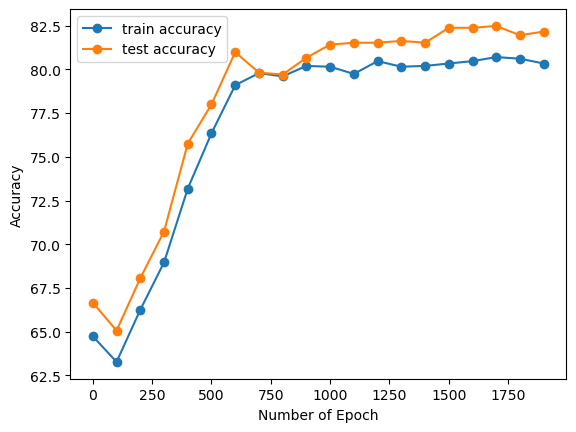

In [21]:
# revert to numpy array
train_acc_list = np.array(torch.tensor(train_acc_list))
test_acc_list = np.array(torch.tensor(test_acc_list))

plt.plot(epoch_count, train_acc_list , label = 'train accuracy', marker='o')
plt.plot(epoch_count, test_acc_list, label = 'test accuracy', marker='o')

plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()

##  Decision Boundary

In [22]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.8) # play with opacity of decision boundary
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.3) # play with opacity of features
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

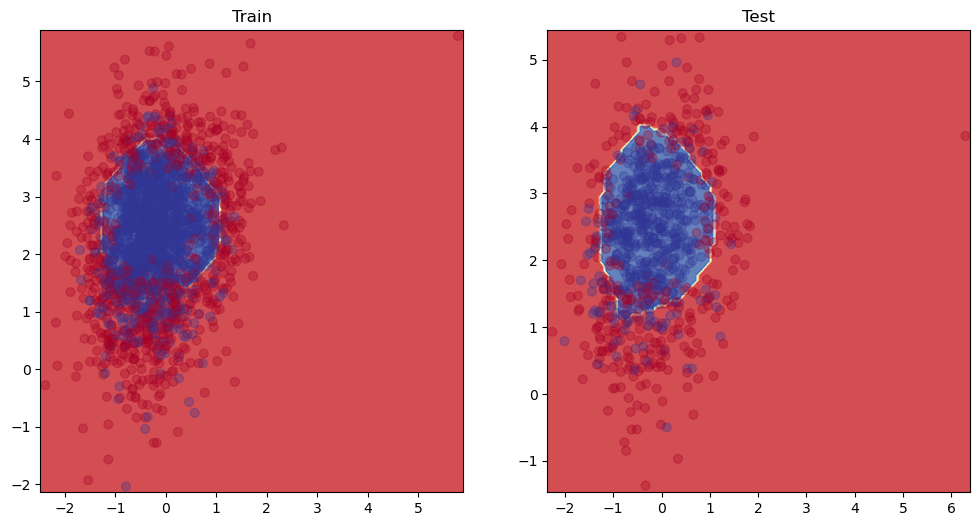

In [23]:
# Visualize! Visualize! Visualize!
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## Confusion Matrix

In [1]:
from sklearn.metrics import confusion_matrix
model_matrix = confusion_matrix(y_test, test_pred)
model_matrix

NameError: name 'y_test' is not defined

<AxesSubplot:>

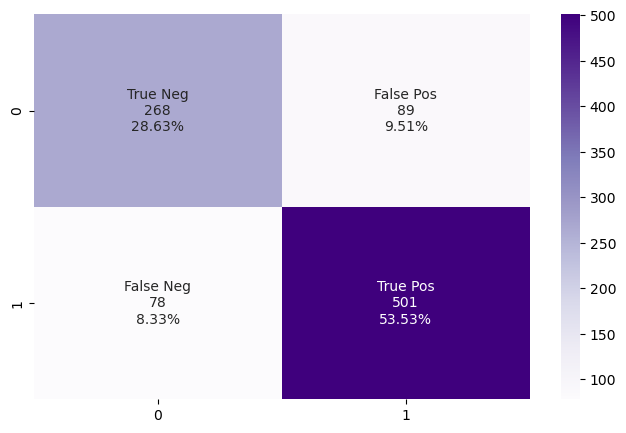

In [25]:
# Visualize
fig, ax = plt.subplots(figsize=(8,5))
# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

## Enhancing Model Performance Through Hyperparameter Tuning
If the current results are unsatisfactory, the hyperparameter values can be adjusted until the desired result is achieved.

1. Increase the number of layers (network layer/dense)
2. Increase the number of hidden units (neurons/perceptrons) 
3. Increase the training duration by fitting the model for more epochs
4. Experiment with different activation functions to find the most suitable one for the model.
5. Adjust the learning rate of the model to improve its performance.

***